# Introduction

Author: Lukas Reber

This notebook contains all the code for the Deep Learning Mini Challenge 2. In this MC, we implement a version of the Paper [Show and Tell: A Neural Image Caption Generator](https://arxiv.org/pdf/1411.4555). The implemented model contains of a CNN encoder and a LSTM decoder and is trained to create captions for images. The model is trained on the [Flickr8k](https://www.kaggle.com/adityajn105/flickr8k) dataset. This dataset contains 8091 images with 5 captions each.


## Imports and Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast
import matplotlib.style as style
from PIL import Image
import matplotlib.patches as patches
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_packed_sequence
from torchvision import transforms
import torchtext; torchtext.disable_torchtext_deprecation_warning()
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab, GloVe
from collections import Counter

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.backends.mps.is_available() else device
print(f'Using device: {device}')

style.use('ggplot')
np.random.seed(0)
torch.manual_seed(0)

# because of memory issues, we need to set the high watermark to 0.0
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

Using device: mps


# Data Analysis

In [2]:
captions = pd.read_csv('data/captions.txt')
image_path = 'data/Images'
# Get a list of all files in the directory
all_images = os.listdir(image_path)

# Nr of captions
print(f'Nr of captions: {captions.shape[0]}')
# Nr of images
print(f'Nr of images: {len(os.listdir(image_path))}')

Nr of captions: 40455
Nr of images: 8091


## Sample Images

Initially we visualize some sample images from the dataset. 

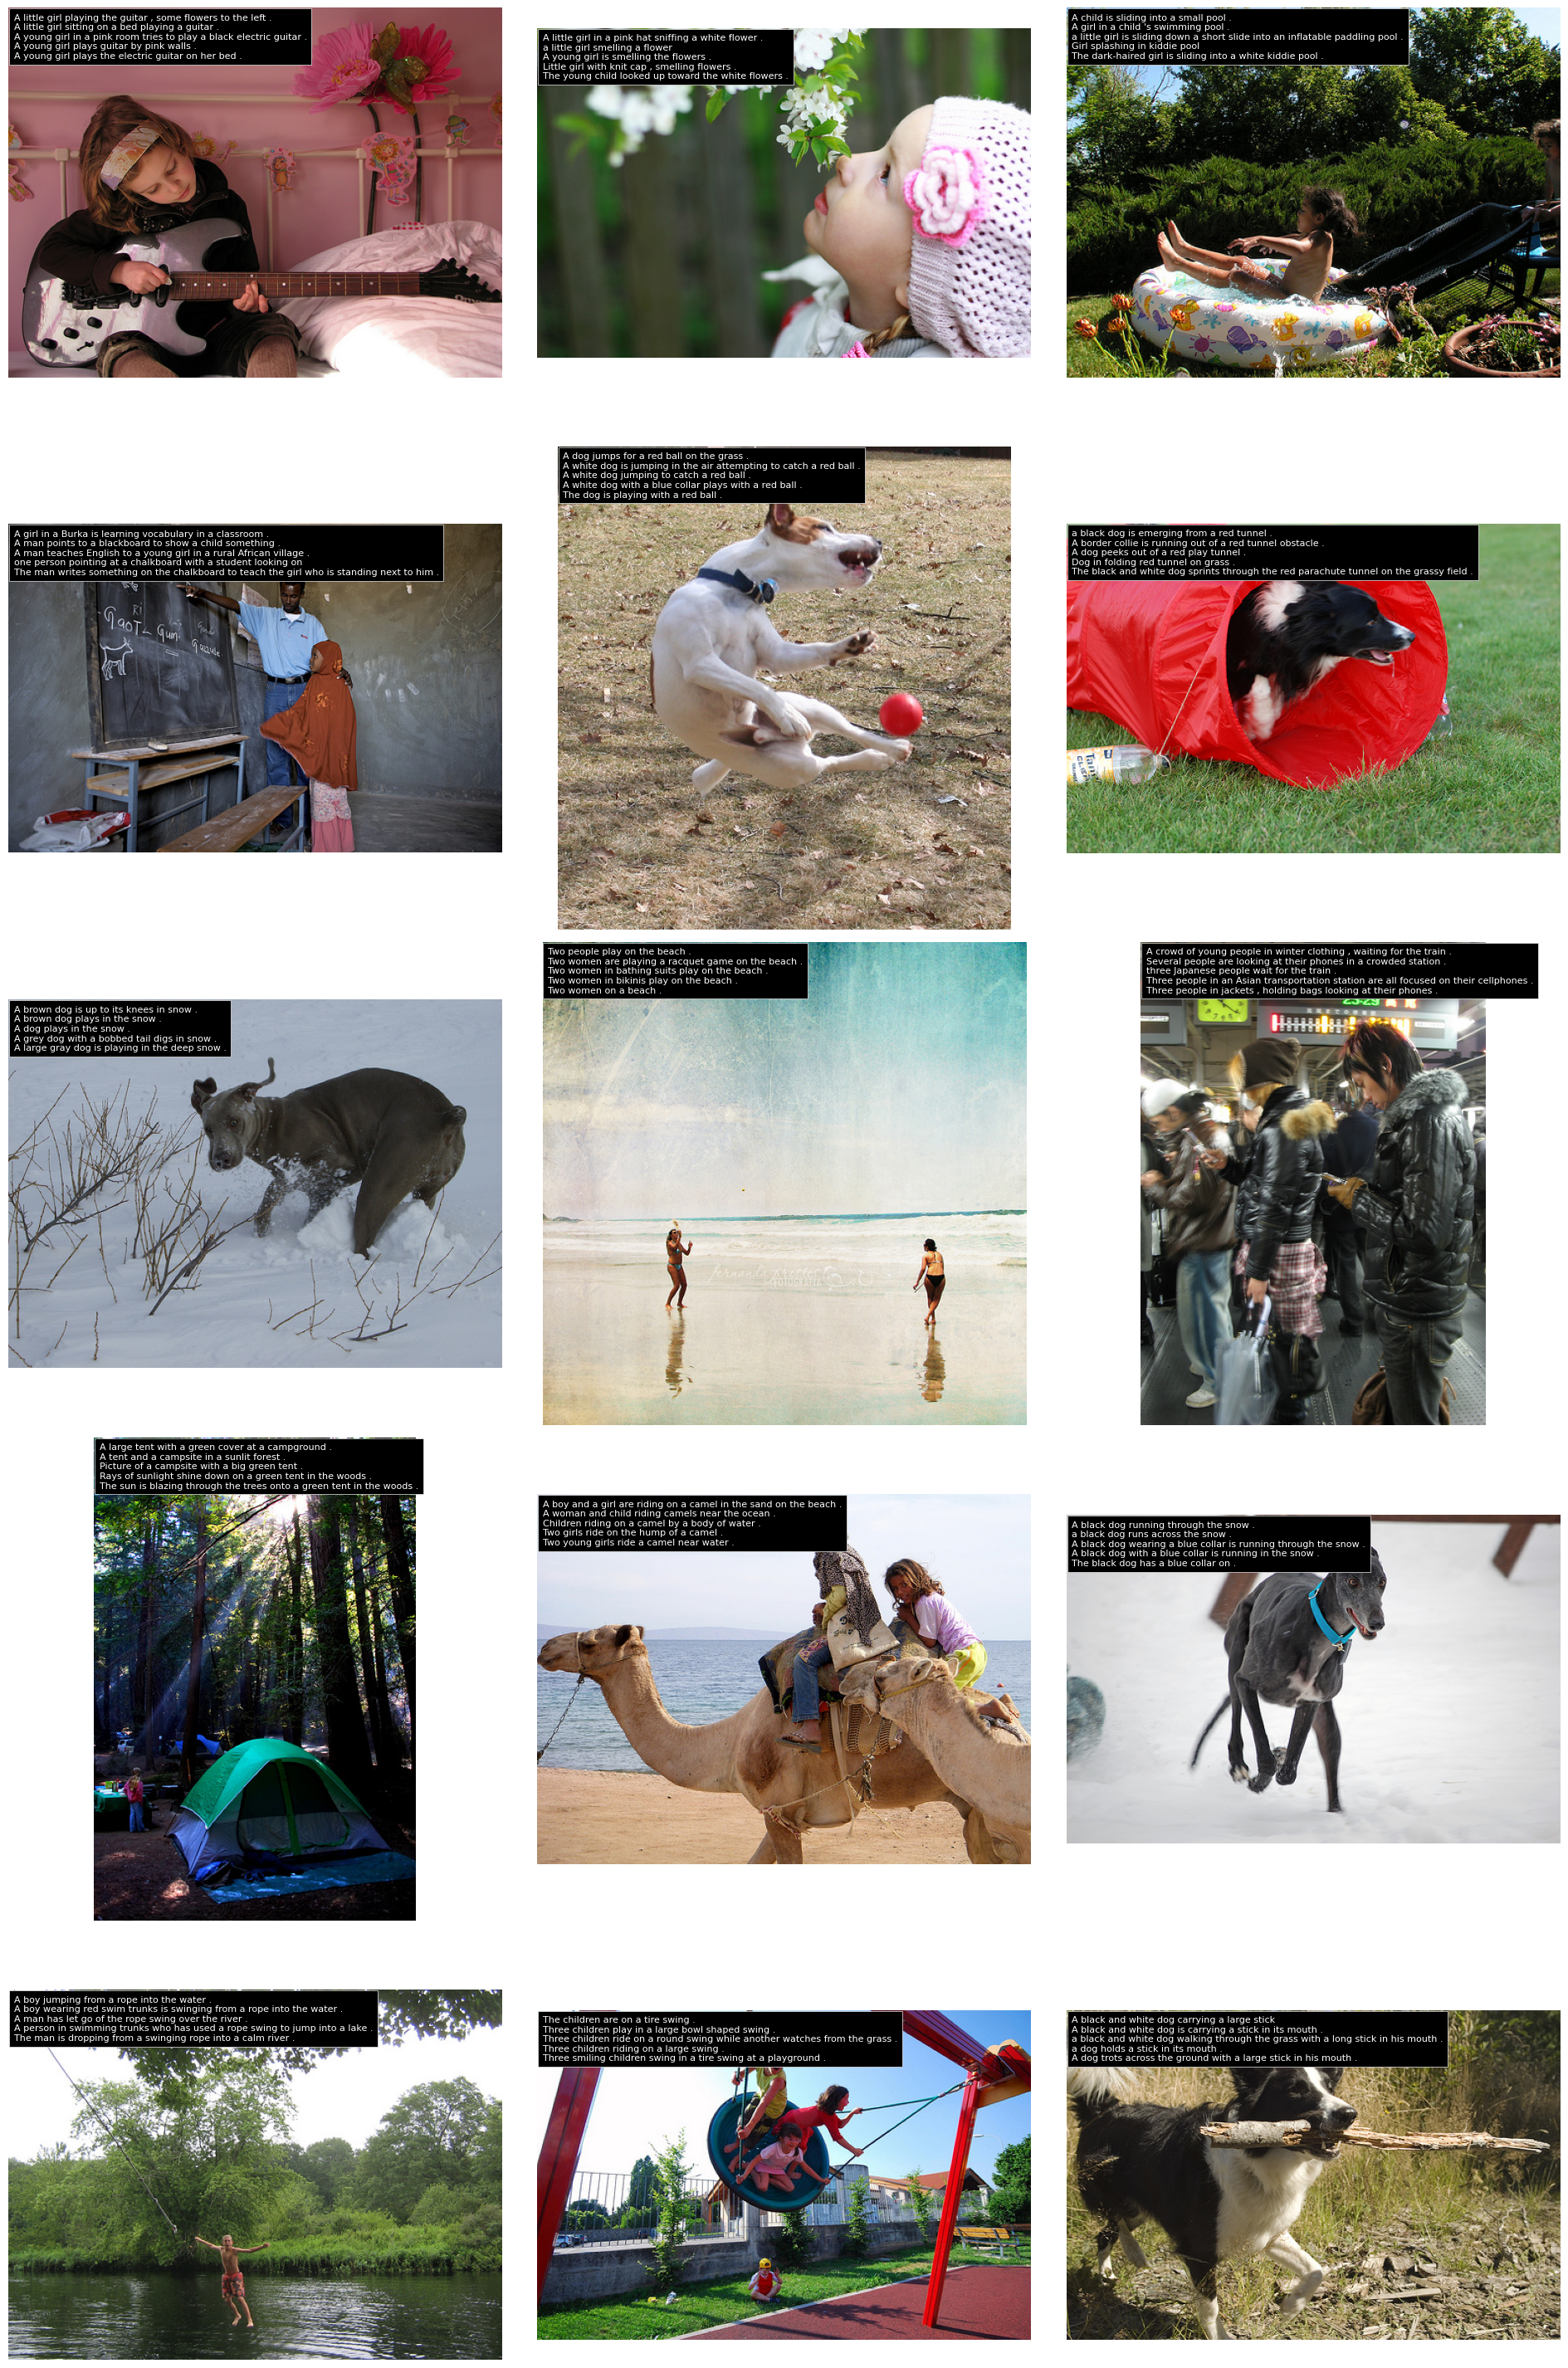

In [4]:
# display sample images with captions
fig, axs = plt.subplots(5, 3, figsize=(20, 30))

for i in axs.flatten():
    img_file = np.random.choice(os.listdir(image_path))
    img = plt.imread(os.path.join(image_path, img_file))
    i.imshow(img)
    caps = '\n'.join(captions[captions['image'] == img_file]['caption'].values)
    i.text(5, 5, caps, fontsize=8, horizontalalignment='left', verticalalignment='top', color='white', bbox=dict(facecolor='black'))
    i.axis('off')
fig.tight_layout()
plt.show()

We can see from the sample images that the images are of different sizes and have different aspect ratios. This is important to keep in mind when preprocessing the images. Adittionally, we can see that the captions generally focus on the main object of the image. For example, if there is a person in the image, all of the captions will mention the person but with different descriptive features.

## Caption Length

In [5]:
captions['lenght'] = captions['caption'].apply(lambda x: len(x.split()))
captions['n_characters'] = captions['caption'].apply(lambda x: len(x))

In [6]:
max(captions['lenght'])
np.mean(captions['lenght'])

11.78259794833766

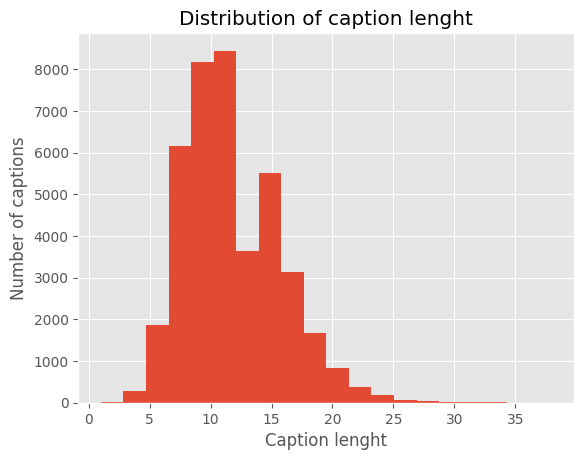

In [7]:
captions['lenght'].hist(bins=20)
plt.title('Distribution of caption lenght')
plt.xlabel('Caption lenght')
plt.ylabel('Number of captions')
plt.show()

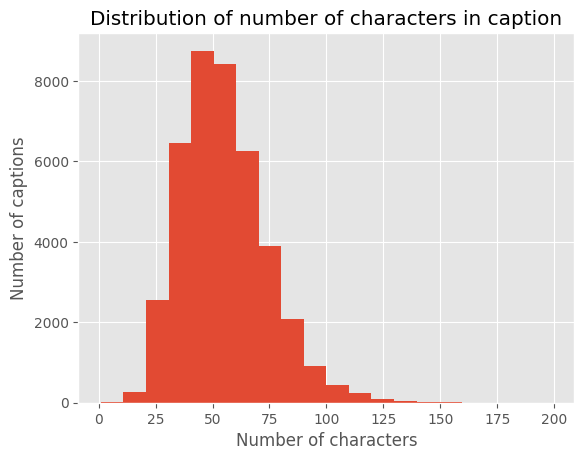

In [8]:
captions['n_characters'].hist(bins=20)
plt.title('Distribution of number of characters in caption')
plt.xlabel('Number of characters')
plt.ylabel('Number of captions')
plt.show()

## Word occurences

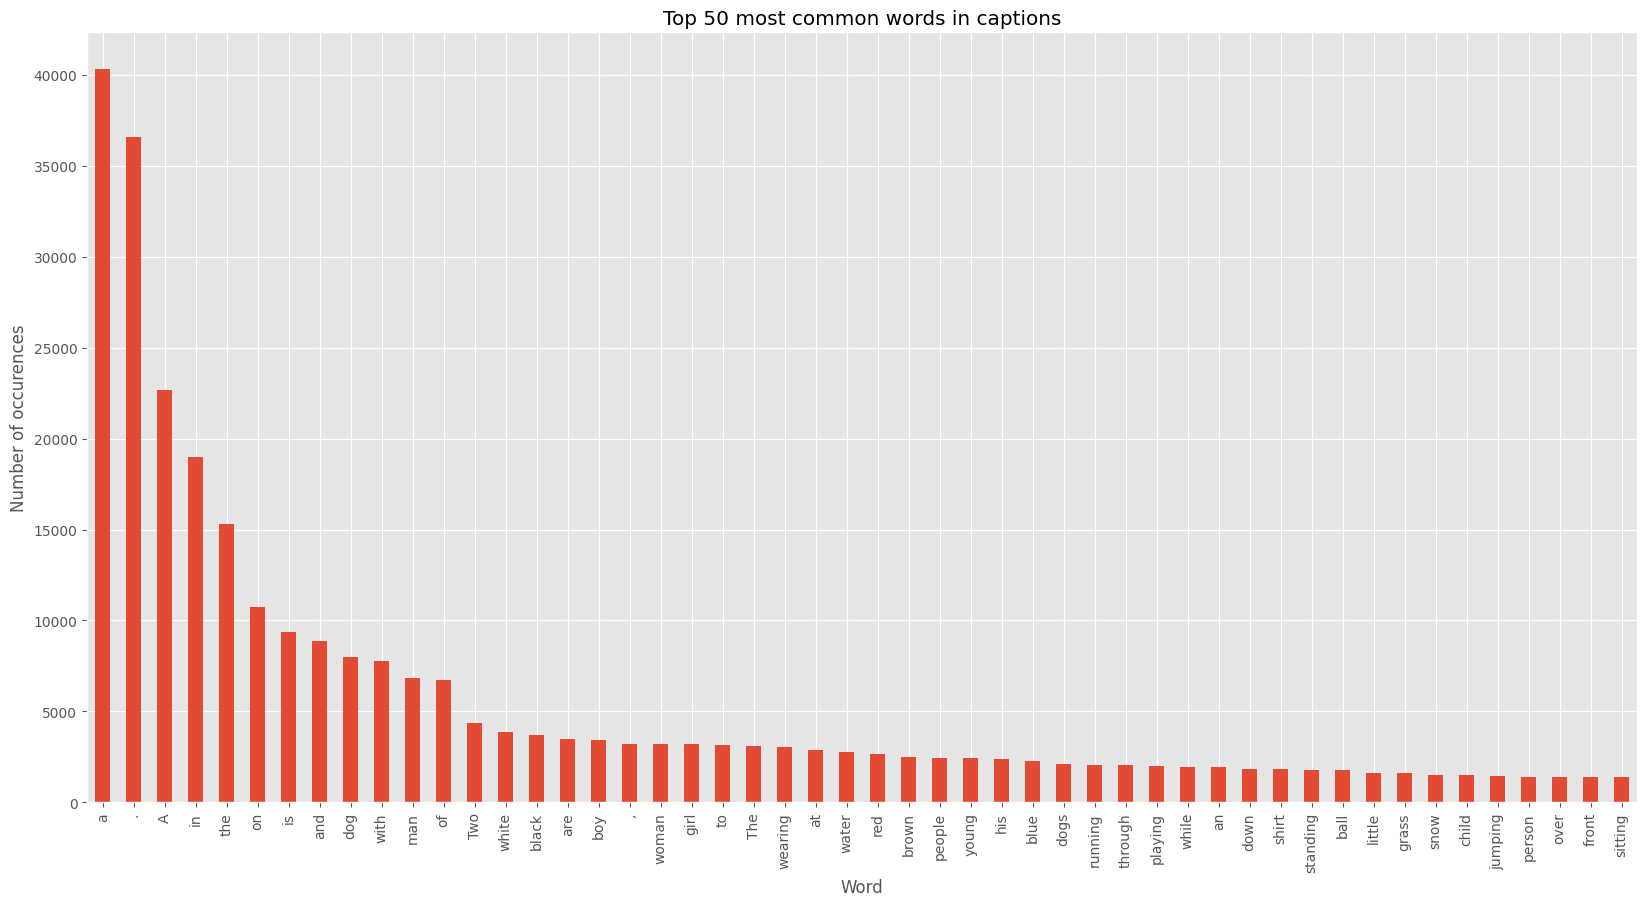

In [9]:
words = captions['caption'].str.split().sum()
words = pd.Series(words)
word_counts = words.value_counts()

word_counts.head(50).plot(kind='bar', figsize=(20, 10))
plt.title('Top 50 most common words in captions')
plt.xlabel('Word')
plt.ylabel('Number of occurences')
plt.show()

## Image Size / Ratio

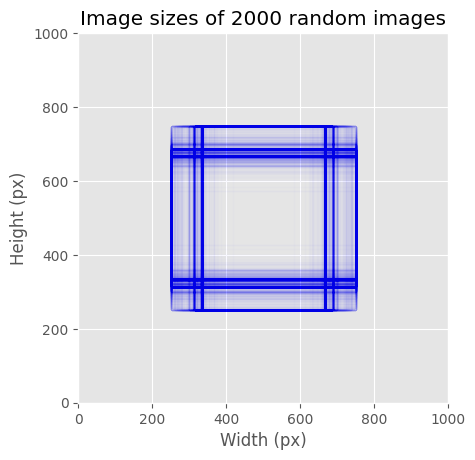

In [9]:
sample_images = np.random.choice(all_images, 2000)

fig, ax = plt.subplots(1,1)
for image in sample_images:
    img = Image.open(os.path.join(image_path, image))
    width, height = img.size
    position = (500- width/2, 500 - height/2)
    rectangle = patches.Rectangle(position, width, height, edgecolor='blue', facecolor='none', alpha=0.01, linewidth=1)
    ax.add_patch(rectangle)

plt.title('Image sizes of 2000 random images')
plt.xlabel('Width (px)')
plt.ylabel('Height (px)')

ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)
ax.set_aspect('equal')
plt.show()

In [10]:
# Max image width and height
max_width = 0
max_height = 0
for image in all_images:
    img = Image.open(os.path.join(image_path, image))
    width, height = img.size
    max_width = max(max_width, width)
    max_height = max(max_height, height)

print(f'Max image width: {max_width}')
print(f'Max image height: {max_height}')

Max image width: 500
Max image height: 500


# Data prearation

## Prepare Images

Since not all images are the same size, but this is a requirement for the model, we will add padding to the images to make them all the same size. The maximum width and height from all images is 500 pixels, so we will resize all images to 500x500 pixels. Other options would be to either crop the images, but this would result in loss of information, which we want to avoid, or repeat the border pixels to fill the image, but this would result in a lot of noise in the images.

In [10]:
max_width = 500
max_height = 500

for image in tqdm(all_images):
    img = Image.open(os.path.join(image_path, image))
    width, height = img.size
    # cacluate padding
    pad_left = (max_width - width) // 2
    pad_right = max_width - width - pad_left
    pad_top = (max_height - height) // 2
    pad_bottom = max_height - height - pad_top
    # create padding
    padded_img = transforms.Pad(padding=(pad_left, pad_top, pad_right, pad_bottom), fill=0, padding_mode='constant')(img)
    # save image
    padded_img.save(f'data/Images_prepared/{image}')


  0%|          | 0/8091 [00:00<?, ?it/s]

In [11]:
# check all image sizes are 500x500
for image in all_images:
    assert Image.open(os.path.join('data/Images_prepared', image)).size == (500,500)

## Preprocess and tokenize captions

In order for the model to understand the captions, we need to tokenize them, which means converting the words to integers. But first, a couple of clean up steps are needed:

- Lowercase all words
- Remove punctuation
- Limit the maximum number of words to 20
- Add padding to captions shorter than 20 words
- Mark beginning with \<bos\> and end with \<eos\>, which will result in a total token lenght of 22


In [12]:
tokenizer = get_tokenizer('basic_english')
tokenizer(captions.iloc[1]['caption'])

['a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.']

In [13]:
begin_token = '<bos>'
end_token = '<eos>'
pad_token = '<pad>'
unk_token = '<unk>'

max_caption_lenght = 20

tokenizer = get_tokenizer('basic_english')

def convert_caption(caption):
    
    # tokenize caption
    process_caption = tokenizer(caption)
    # remove punctuations (only keep alphanumeric characters)
    process_caption = [word for word in process_caption if word.isalnum()]
    # shorten caption to max_caption_lenght
    process_caption = process_caption[:max_caption_lenght]
    # add begin and end token
    process_caption = [begin_token] + process_caption + [end_token]
    # add padding
    process_caption += [pad_token] * (max_caption_lenght + 2 - len(process_caption))
    
    return process_caption
    
captions['tokens'] = captions['caption'].apply(convert_caption)

In [14]:
captions.head(10)

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  lenght  n_characters  \
0  A child in a pink dress is climbing up a set o...      18            72   
1              A girl going into a wooden building .       8            37   
2   A little girl climbing into a wooden playhouse .       9            48   
3  A little girl climbing the stairs to her playh...      10            52   
4  A little girl in a pink dress going into a woo...      13            57   
5         A black dog and a spotted dog are fighting       9            42   
6  A black dog and a tri-colored dog playing with...      15            71   
7  A black dog and a white dog with brown spots a...      19            86   
8  Two dogs of different breeds looking at each o...      13            64   
9    Two dogs on pavement moving toward each other .       9            47   

                                              tokens  
0  [<bos>, a, child, in, a, pink, dress, is, clim...  
1  [<bos>, a, girl, going, into, a, wooden, build...  
2  [<bos>, a, little, girl, climbing, into, a, wo...  
3  [<bos>, a, little, girl, climbing, the, stairs...  
4  [<bos>, a, little, girl, in, a, pink, dress, g...  
5  [<bos>, a, black, dog, and, a, spotted, dog, a...  
6  [<bos>, a, black, dog, and, a, dog, playing, w...  
7  [<bos>, a, black, dog, and, a, white, dog, wit...  
8  [<bos>, two, dogs, of, different, breeds, look...  
9  [<bos>, two, dogs, on, pavement, moving, towar...

In [15]:
captions.to_csv('data/captions_prepared.csv', index=False)

# Create Embeddings

In [61]:
# Expand the list of tokens and count the frequency of each word
vocab_count = Counter(captions['tokens'].explode())

voc = vocab(
    vocab_count, 
    min_freq=0, 
    specials=[begin_token, end_token, pad_token, unk_token])

glove = GloVe(name='6B', dim=100)

voc

IndexError: too many indices for tensor of dimension 2

In [17]:
def get_embeddings(tokens):
    # Get the embeddings for each token
    embeddings = [voc.get_stoi()[token] for token in tokens]
    return embeddings

# create embeddings if the exported csv does not exist
if not os.path.exists('data/captions_prepared.csv'):
    captions['embeddings'] = captions['tokens'].apply(get_embeddings)
    captions.to_csv('data/captions_prepared.csv', index=False)
else:
    captions = pd.read_csv('data/captions_embeddings.csv')
    captions['tokens'] = captions['tokens'].apply(ast.literal_eval)
    captions['embeddings'] = captions['embeddings'].apply(ast.literal_eval)

In [18]:
# test if the embeddings are correct
sample = captions.sample(10)

for i, row in sample.iterrows():
    assert row['tokens'] == [voc.get_itos()[emb] for emb in row['embeddings']]

# Data Splitting & Dataloader

In order to train the model and later evaluate it on unseen data, we need to split the data into a training and validation set. We will use 80% of the data for training and 20% for validation.

In [19]:
# get unique files
unique_files = captions['image'].unique()
# split the files into train and test
files_train, files_test = train_test_split(unique_files, test_size=0.2, random_state=0) 

# split the captions into train and test
captions_train = captions[captions['image'].isin(files_train)]
captions_test = captions[captions['image'].isin(files_test)]

print(f'Nr of training captions: {captions_train.shape[0]}')
print(f'Nr of test captions: {captions_test.shape[0]}')

Nr of training captions: 32360
Nr of test captions: 8095


In [20]:
# create a dataset class to read the caption and images
class ImageCaptionDataset(Dataset):
    def __init__(self, dataframe, image_path, transform=None):
        self.dataframe = dataframe
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(os.path.join(self.image_path, row['image']))

        if self.transform:
            image = self.transform(image)

        else:
            image = transforms.ToTensor()(image)

        return image, torch.tensor(row['embeddings'])

In [21]:
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])
train = ImageCaptionDataset(captions_train, image_path='data/Images_prepared', transform=None)
test = ImageCaptionDataset(captions_test, image_path='data/Images_prepared', transform=None)

In [38]:
batch_size = 64
shuffle = True

dataloader_train = DataLoader(train, batch_size=batch_size, shuffle=shuffle)
dataloader_test = DataLoader(test, batch_size=batch_size, shuffle=shuffle)

In [39]:
# return a single batch from the dataloader
images, captions = next(iter(dataloader_train))
print(f'Images shape: {images.shape}')
print(f'Captions shape: {captions.shape}')

Images shape: torch.Size([64, 3, 500, 500])
Captions shape: torch.Size([64, 22])


The shape of the images tensor is [batch_size, num_channels, height, width], and the shape of the captions tensor is [batch_size, sequence_length]

# Model definition

Our model consists of two parts: An encoder and a decoder. The encoder consists of a pretrained ResNet50 model, which is used to extract image features. We remove the last layer of the ResNet50 model and add a fully connected layer to extract the features as a vector. The decoder is a LSTM model, which takes the image feature vector as input and generates the captions.

Both the encoder and the decoder are combined into a single model, which is then trained end-to-end. The forward method generates the image features using the encoder and then generates the captions using the decoder.

In [57]:
import torch.nn as nn
import torchvision.models as models
import torch.utils.checkpoint as cp


class Encoder(nn.Module):

    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features
    
class Decoder(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, pt_emb=True):
        super(Decoder, self).__init__()
        if pt_emb:
            self.embed = nn.Embedding.from_pretrained(voc.vectors, freeze=True)
        else:
            self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.reduce_dim = nn.Linear(2*embed_size, embed_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        # print(np.shape(features))
        # print(np.shape(embeddings))
        # features = features.unsqueeze(1).repeat(1, embeddings.size(1), 1)
        features = features.unsqueeze(1).expand(-1, embeddings.size(1), -1)
        embeddings = torch.cat((features, embeddings), 2)
        # embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        embeddings = self.reduce_dim(embeddings)
        hiddens, _ = self.lstm(embeddings)
        # hiddens, _ = cp.checkpoint(self.lstm, embeddings)
        outputs = self.linear(hiddens)
        return outputs
    

class ImageCaptionModel(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, pt_emb=True):
        super(ImageCaptionModel, self).__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers, pt_emb=pt_emb)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs
    
    # sample a caption from the model
    def sample(self, image, voc, max_len=22, end_token='<eos>'):
        result_caption = []
        with torch.no_grad():
            x = self.encoder(image).unsqueeze(0)
            states = None
            for _ in range(max_len):
                hiddens, states = self.decoder.lstm(x, states)
                output = self.decoder.linear(hiddens)
                predicted = output.argmax(1)
                print(predicted)
                result_caption.append(predicted.item())
                x = self.decoder.embed(predicted).unsqueeze(0)
                if voc.itos[predicted.item()] == end_token:
                    break
        return result_caption


# Model Training

In [58]:
embed_size = 100
hidden_size = 100
vocab_size = len(voc)
num_layers = 1

model = ImageCaptionModel(embed_size, hidden_size, vocab_size, num_layers, pt_emb=True).to(device)

/Users/lukasreber/Repositories/del_mc2/del_mc2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lukasreber/Repositories/del_mc2/del_mc2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AttributeError: 'Vocab' object has no attribute 'vectors'

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [43]:
num_epochs = 5
for epoch in range(num_epochs):
    for i, (images, captions) in enumerate(dataloader_train):
        images = images.to(device)
        captions = captions.to(device)

        outputs = model(images, captions)
        targets = captions[:, 1:]
        outputs = outputs[:, :-1, :]
        # loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f'Epoch {epoch}, Batch {i}, Loss: {loss.item()}')

Epoch 0, Batch 0, Loss: 9.039352416992188
Epoch 0, Batch 100, Loss: 3.130214214324951
Epoch 0, Batch 200, Loss: 3.153949499130249
Epoch 0, Batch 300, Loss: 2.7167484760284424
Epoch 0, Batch 400, Loss: 2.778916597366333
Epoch 0, Batch 500, Loss: 2.638472080230713
Epoch 1, Batch 0, Loss: 2.663992404937744
Epoch 1, Batch 100, Loss: 2.4938886165618896
Epoch 1, Batch 200, Loss: 2.4969043731689453
Epoch 1, Batch 300, Loss: 2.321739673614502
Epoch 1, Batch 400, Loss: 2.2001163959503174
Epoch 1, Batch 500, Loss: 2.145138740539551
Epoch 2, Batch 0, Loss: 2.043473482131958
Epoch 2, Batch 100, Loss: 2.1170246601104736
Epoch 2, Batch 200, Loss: 2.15419864654541
Epoch 2, Batch 300, Loss: 2.0244016647338867
Epoch 2, Batch 400, Loss: 2.171657085418701
Epoch 2, Batch 500, Loss: 2.1658084392547607
Epoch 3, Batch 0, Loss: 1.9011539220809937
Epoch 3, Batch 100, Loss: 1.9938576221466064
Epoch 3, Batch 200, Loss: 1.9255530834197998
Epoch 3, Batch 300, Loss: 1.9406312704086304
Epoch 3, Batch 400, Loss: 1.99

In [44]:
# save the model
torch.save(model, 'data/Models/v00001.pt')

In [52]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    return image

image_path = 'data/Images_prepared/12830823_87d2654e31.jpg'
image = preprocess_image(image_path)
caption_indices = model.sample(image, voc)

# Convert indices to words
caption = ' '.join([voc.itos[idx] for idx in caption_indices])
print(caption)

RuntimeError: a Tensor with 8405 elements cannot be converted to Scalar